<a href="https://colab.research.google.com/github/sampathweb/char_rnn_text_gen/blob/master/RNN_Text_Gen_Char_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## RNN Text Generation - Based on D2AI Study Group Notebook

In [2]:
# Alice in wonderland book
# You can use anybook in any language of your choice and see how it performs.
import requests
content = requests.get("http://www.gutenberg.org/cache/epub/11/pg11.txt").text
with open("wonderland.txt", "w", encoding="utf-8") as f:
  f.write(content)

In [3]:
# Print first few lines of the text book
print(content[:500])

﻿Project Gutenberg's Alice's Adventures in Wonderland, by Lewis Carroll

This eBook is for the use of anyone anywhere at no cost and with
almost no restrictions whatsoever.  You may copy it, give it away or
re-use it under the terms of the Project Gutenberg License included
with this eBook or online at www.gutenberg.org


Title: Alice's Adventures in Wonderland

Author: Lewis Carroll

Posting Date: June 25, 2008 [EBook #11]
Release Date: March, 1994
[Last updated: December 20, 2011


In [4]:
from string import punctuation

import numpy as np
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import functional as F

In [5]:
# Sets Hyper-Parameters
sequence_length = 100
batch_size = 128

# dataset file path
FILE_PATH = "wonderland.txt"

# read the data
text = open(FILE_PATH, encoding="utf-8").read()

# remove caps, comment this code if you want uppercase characters as well
text = text.lower()
# remove punctuation
text = text.translate(str.maketrans("", "", punctuation))[1:]

In [6]:
print(text[:500])

project gutenbergs alices adventures in wonderland by lewis carroll

this ebook is for the use of anyone anywhere at no cost and with
almost no restrictions whatsoever  you may copy it give it away or
reuse it under the terms of the project gutenberg license included
with this ebook or online at wwwgutenbergorg


title alices adventures in wonderland

author lewis carroll

posting date june 25 2008 ebook 11
release date march 1994
last updated december 20 2011

language english


 start of this 


In [7]:
# print some stats
n_chars = len(text)
vocab = ''.join(sorted(set(text)))
print("unique_chars:", vocab)
n_unique_chars = len(vocab)
print("Number of characters:", n_chars)
print("Number of unique characters:", n_unique_chars)

unique_chars: 
 0123456789abcdefghijklmnopqrstuvwxyz
Number of characters: 154860
Number of unique characters: 38


In [8]:
# Vocab is all the chars (A-Z, 0-9, new line char)
vocab

'\n 0123456789abcdefghijklmnopqrstuvwxyz'

In [9]:
# dictionary that converts characters to integers
char2int = {c: i for i, c in enumerate(vocab)}
# dictionary that converts integers to characters
int2char = {i: c for i, c in enumerate(vocab)}

In [10]:
print(char2int)

{'\n': 0, ' ': 1, '0': 2, '1': 3, '2': 4, '3': 5, '4': 6, '5': 7, '6': 8, '7': 9, '8': 10, '9': 11, 'a': 12, 'b': 13, 'c': 14, 'd': 15, 'e': 16, 'f': 17, 'g': 18, 'h': 19, 'i': 20, 'j': 21, 'k': 22, 'l': 23, 'm': 24, 'n': 25, 'o': 26, 'p': 27, 'q': 28, 'r': 29, 's': 30, 't': 31, 'u': 32, 'v': 33, 'w': 34, 'x': 35, 'y': 36, 'z': 37}


In [11]:
print(int2char)

{0: '\n', 1: ' ', 2: '0', 3: '1', 4: '2', 5: '3', 6: '4', 7: '5', 8: '6', 9: '7', 10: '8', 11: '9', 12: 'a', 13: 'b', 14: 'c', 15: 'd', 16: 'e', 17: 'f', 18: 'g', 19: 'h', 20: 'i', 21: 'j', 22: 'k', 23: 'l', 24: 'm', 25: 'n', 26: 'o', 27: 'p', 28: 'q', 29: 'r', 30: 's', 31: 't', 32: 'u', 33: 'v', 34: 'w', 35: 'x', 36: 'y', 37: 'z'}


In [12]:
# convert all text into integers
encoded_text = np.array([char2int[c] for c in text])

In [13]:
len(encoded_text), len(text)

(154860, 154860)

In [14]:
text[:25]

'project gutenbergs alices'

In [17]:
# Corresponding encoded numbers.  Verify that these chars have the same number in char2int
encoded_text[:25]

array([27, 29, 26, 21, 16, 14, 31,  1, 18, 32, 31, 16, 25, 13, 16, 29, 18,
       30,  1, 12, 23, 20, 14, 16, 30])

In [18]:
# tokenize  input_seq, target_seq
def create_sequence_data(text, sequence_length):
  input_seq = []
  target_seq = []
  for idx in range(0, len(text), sequence_length):
    st_idx = idx
    end_idx = st_idx + sequence_length + 1
    if end_idx > len(text):
      # Exclude last slice that may not be full
      continue
    input_seq.append(text[st_idx:end_idx-1])
    target_seq.append(text[st_idx+1:end_idx])
  return input_seq, target_seq

In [19]:
input_seq, target_seq = create_sequence_data(encoded_text, sequence_length=sequence_length)

In [20]:
input_seq[0:3]

[array([27, 29, 26, 21, 16, 14, 31,  1, 18, 32, 31, 16, 25, 13, 16, 29, 18,
        30,  1, 12, 23, 20, 14, 16, 30,  1, 12, 15, 33, 16, 25, 31, 32, 29,
        16, 30,  1, 20, 25,  1, 34, 26, 25, 15, 16, 29, 23, 12, 25, 15,  1,
        13, 36,  1, 23, 16, 34, 20, 30,  1, 14, 12, 29, 29, 26, 23, 23,  0,
         0, 31, 19, 20, 30,  1, 16, 13, 26, 26, 22,  1, 20, 30,  1, 17, 26,
        29,  1, 31, 19, 16,  1, 32, 30, 16,  1, 26, 17,  1, 12, 25]),
 array([36, 26, 25, 16,  1, 12, 25, 36, 34, 19, 16, 29, 16,  1, 12, 31,  1,
        25, 26,  1, 14, 26, 30, 31,  1, 12, 25, 15,  1, 34, 20, 31, 19,  0,
        12, 23, 24, 26, 30, 31,  1, 25, 26,  1, 29, 16, 30, 31, 29, 20, 14,
        31, 20, 26, 25, 30,  1, 34, 19, 12, 31, 30, 26, 16, 33, 16, 29,  1,
         1, 36, 26, 32,  1, 24, 12, 36,  1, 14, 26, 27, 36,  1, 20, 31,  1,
        18, 20, 33, 16,  1, 20, 31,  1, 12, 34, 12, 36,  1, 26, 29]),
 array([ 0, 29, 16, 32, 30, 16,  1, 20, 31,  1, 32, 25, 15, 16, 29,  1, 31,
        19, 16,  1, 31, 

In [21]:
#Notice that Target Sequence is just one value offset from inputs.  So given previous chars, predicts next Char.
target_seq[0:3]

[array([29, 26, 21, 16, 14, 31,  1, 18, 32, 31, 16, 25, 13, 16, 29, 18, 30,
         1, 12, 23, 20, 14, 16, 30,  1, 12, 15, 33, 16, 25, 31, 32, 29, 16,
        30,  1, 20, 25,  1, 34, 26, 25, 15, 16, 29, 23, 12, 25, 15,  1, 13,
        36,  1, 23, 16, 34, 20, 30,  1, 14, 12, 29, 29, 26, 23, 23,  0,  0,
        31, 19, 20, 30,  1, 16, 13, 26, 26, 22,  1, 20, 30,  1, 17, 26, 29,
         1, 31, 19, 16,  1, 32, 30, 16,  1, 26, 17,  1, 12, 25, 36]),
 array([26, 25, 16,  1, 12, 25, 36, 34, 19, 16, 29, 16,  1, 12, 31,  1, 25,
        26,  1, 14, 26, 30, 31,  1, 12, 25, 15,  1, 34, 20, 31, 19,  0, 12,
        23, 24, 26, 30, 31,  1, 25, 26,  1, 29, 16, 30, 31, 29, 20, 14, 31,
        20, 26, 25, 30,  1, 34, 19, 12, 31, 30, 26, 16, 33, 16, 29,  1,  1,
        36, 26, 32,  1, 24, 12, 36,  1, 14, 26, 27, 36,  1, 20, 31,  1, 18,
        20, 33, 16,  1, 20, 31,  1, 12, 34, 12, 36,  1, 26, 29,  0]),
 array([29, 16, 32, 30, 16,  1, 20, 31,  1, 32, 25, 15, 16, 29,  1, 31, 19,
        16,  1, 31, 16, 

In [22]:
train_seq, valid_seq, train_targets, valid_targets = train_test_split(input_seq, target_seq, test_size=0.1)

In [23]:
# Each Seq line is of lenghth 100
len(train_seq), len(valid_seq)

(1393, 155)

In [24]:
def one_hot_encode(sequence, vocab_size):
    """Inputs need to be converted to one-hot encoded vectors to feed into RNN"""
    # Creating a multi-dimensional array of zeros with the desired output shape
    # (Sequence Length, One-Hot Encoding Size)
    seq_length = len(sequence)
    output = np.zeros((seq_length, vocab_size), dtype=np.float32)

    for seq in range(seq_length):
      output[seq, sequence[seq]] = 1
    
    return output

In [25]:
# Test it with a simple sequence
# You can verify that encoding for hello world manually
sample_text = "hello world"
sample_encoded_text = np.array([char2int[c] for c in sample_text])
print(sample_text, sample_encoded_text)
one_hot_encode(sample_encoded_text, len(vocab)).shape

hello world [19 16 23 23 26  1 34 26 29 23 15]


(11, 38)

In [26]:
class TextGenDataset(Dataset):
  """Create a PyTorch Dataset for the input / target sequence"""
  def __init__(self, text_seq, target_seq, seq_length, vocab_size):
    super().__init__()
    self.text_seq = text_seq
    self.target_seq = target_seq
    self.seq_length = seq_length
    self.vocab_size = vocab_size

  def __getitem__(self, idx):
    return one_hot_encode(self.text_seq[idx], self.vocab_size), self.target_seq[idx]

  def __len__(self):
    return len(self.text_seq)

train_ds = TextGenDataset(train_seq, train_targets, sequence_length, len(vocab))
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=False, drop_last=True)

valid_ds = TextGenDataset(valid_seq, valid_targets, sequence_length, len(vocab))
valid_dl = DataLoader(valid_ds, batch_size=batch_size, drop_last=True)


In [27]:
x, y = train_ds[0]
x.shape, y.shape

((100, 38), (100,))

In [28]:
print(x)
print(y)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
[23 12 31 16  1 34 20 31 19  1 26 25 16  1 17 20 25 18 16 29  1 12 30  1
 19 16  1 17 26 32 25 15  1 20 31  1 24 12 15 16  1 25 26  1 24 12 29 22
  1 13 32 31  1 19 16  1 25 26 34  1 19 12 30 31 20 23 36  0 13 16 18 12
 25  1 12 18 12 20 25  1 32 30 20 25 18  1 31 19 16  1 20 25 22  1 31 19
 12 31  1 34]


In [29]:
for x, y in train_dl:
  break

In [30]:
# Input to Model: Batch_size, sequence_length, vocab_size
# Output of the Model: Batch_size x vocab_size
x.shape, y.shape

(torch.Size([128, 100, 38]), torch.Size([128, 100]))

In [31]:
class Model(nn.Module):
    """Creates a RNN Model with n_layers and hidden_dim"""
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # RNN Layer
        self.rnn = nn.GRU(input_size, hidden_dim, n_layers, batch_first=True)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x, hidden=None):
        
        batch_size = x.size(0)
        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        return out, hidden.detach()

In [32]:
# Instantiate the model with hyperparameters
model = Model(input_size=len(vocab), output_size=len(vocab), hidden_dim=512, n_layers=3)

# Define hyperparameters
n_epochs = 100
lr=0.001
device = "cuda" if torch.cuda.is_available() else "cpu"

# Define Loss, Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [33]:
# Training Run
def train(model, train_dl, criterion, optimizer, batch_size, device=None, n_epochs=100):
  if device is None:
    device = "cuda" if torch.cuda.is_available() else "cpu"
  model = model.to(device)
  model.train()
  criterion = criterion.to(device)
  for epoch in range(1, n_epochs + 1):
    hidden = None
    n_batches = 0
    losses = 0
    for input_seq, target_seq in train_dl:
      input_seq, target_seq = input_seq.to(device), target_seq.to(device)
      optimizer.zero_grad() # Clears existing gradients from previous epoch
      output, hidden = model(input_seq, hidden)
      loss = criterion(output, target_seq.view(-1).long())
      loss.backward() # Does backpropagation and calculates gradients
      optimizer.step() # Updates the weights accordingly
      # hidden.detach_()
      losses += loss.item()
      n_batches += 1
    
    if epoch%10 == 0:
      print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
      print("Loss: {:.4f}".format(losses / n_batches))
  return model

In [34]:
model = train(model, train_dl, criterion, optimizer, batch_size, device, n_epochs=100)

Epoch: 10/100............. Loss: 2.1360
Epoch: 20/100............. Loss: 1.5427
Epoch: 30/100............. Loss: 1.2505
Epoch: 40/100............. Loss: 1.0548
Epoch: 50/100............. Loss: 0.8372
Epoch: 60/100............. Loss: 0.6714
Epoch: 70/100............. Loss: 0.6052
Epoch: 80/100............. Loss: 0.4293
Epoch: 90/100............. Loss: 0.2742
Epoch: 100/100............. Loss: 0.1588


In [35]:
# Loss is decreasing.  Lets Train some more
model = train(model, train_dl, criterion, optimizer, batch_size, device, n_epochs=100)

Epoch: 10/100............. Loss: 0.1246
Epoch: 20/100............. Loss: 0.0987
Epoch: 30/100............. Loss: 0.0366
Epoch: 40/100............. Loss: 0.0197
Epoch: 50/100............. Loss: 0.0152
Epoch: 60/100............. Loss: 0.0124
Epoch: 70/100............. Loss: 0.0105
Epoch: 80/100............. Loss: 0.0091
Epoch: 90/100............. Loss: 0.0080
Epoch: 100/100............. Loss: 0.0071


In [41]:
#Save Model Weights (Download it for future use)
state = {
    "model": model.state_dict(),
    "char2int": char2int,
    "int2char": int2char,
    "n_layers": 3,
    "hidden_dim": 512
}
torch.save(state, "./model_alice.pt")

In [37]:
# Load the saved model 
state = torch.load("model_alice.pt")
model.load_state_dict(state["model"])

{'\n': 0, ' ': 1, '0': 2, '1': 3, '2': 4, '3': 5, '4': 6, '5': 7, '6': 8, '7': 9, '8': 10, '9': 11, 'a': 12, 'b': 13, 'c': 14, 'd': 15, 'e': 16, 'f': 17, 'g': 18, 'h': 19, 'i': 20, 'j': 21, 'k': 22, 'l': 23, 'm': 24, 'n': 25, 'o': 26, 'p': 27, 'q': 28, 'r': 29, 's': 30, 't': 31, 'u': 32, 'v': 33, 'w': 34, 'x': 35, 'y': 36, 'z': 37}


In [38]:
def predict(model, hidden, character, char2int, int2char, device):
    # One-hot encoding our input to fit into the model
    # print(character)
    character = np.array([char2int[c] for c in character])
    # print(character)
    character = one_hot_encode(character, vocab_size=len(char2int))
    # print(character.shape)
    character = torch.from_numpy(character).unsqueeze(0).to(device)
    with torch.no_grad():
      out, hidden = model(character, hidden)
    # print(hidden.size())
    prob = nn.functional.softmax(out[-1], dim=0).data
    # Taking the class with the highest probability score from the output
    char_ind = torch.max(prob, dim=0)[1].item()

    return int2char[char_ind], hidden

In [39]:
def sample(model, char2int, int2char, out_len, start='hey', device=None):
    model.eval() # eval mode
    if device is None:
      device = "cuda" if torch.cuda.is_available() else "cpu"    
    model.to(device)
    start = start.lower()
    # First off, run through the starting characters
    chars = [ch for ch in start]
    size = out_len - len(chars)
    # Now pass in the previous characters and get a new one
    hidden = None
    char, hidden = predict(model, hidden, chars, char2int, int2char, device)
    for ii in range(size):
        # Use last char and hidden state to generate next char
        char, hidden = predict(model, hidden, chars[-1], char2int, int2char, device)
        chars.append(char)  # Add the predicted char to output
    return ''.join(chars)

In [40]:
print(sample(model, char2int, int2char, out_len=2000, start="Alice woke up "))

alice woke up you at once she found it very hard indeed to make out ed you are all pardoned come thats a good
thing she said to herself for she had felt quite relieved to see
it trot a bod of which are confirmed as public domain in the us
unless a copyright  destroy all copies of the works possessed in a physical medium
     and discontinue all use of and pour the waters of the nile
      on every golden scale

     how could he turn them
out with the
lory who at last turned sulky and would only say i a sort of it then alice thinking it was
very like having a great thistle
to keep herself from being rubbit

but when the tide rises and sharks are around
  his voice has a timid and tremulouse so alice replied thought
apouse come on and ran the faster while more and more faintly
came carried on the bank with her
head impatiently and walked a little quietly and went on that begins with an m such as
mouse and
they pinched it on both sides at once

the dormouse slowly opened his eyes i wasnt

In [ ]:
# !pip install -q gradio

In [ ]:
# import gradio as gr

# # Still work in Progress
# def qa_func(start):
#     return sample(model, char2int, int2char, out_len, start='hey', device=None)

In [ ]:
# gr.Interface(qa_func, 
#     [
#         gr.inputs.Textbox(lines=3, label="Context"), 
#     ], 
#     gr.outputs.Textbox(label="Generated Text..."),
#     title="Alice in Wonderland").launch()

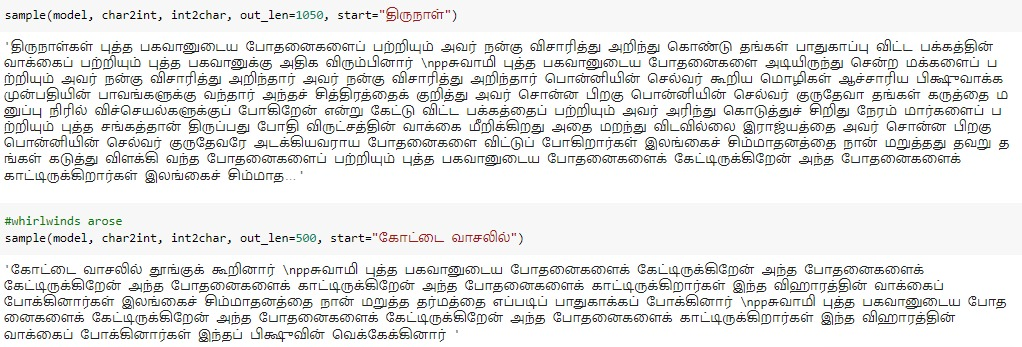

In [ ]:
# This same process can be used to generate any text.  
# Sudharsan (ML Tokyo Study group) used the notebook to generate Tamil Literature Text using this notebook as template.
from IPython.display import Image
Image(filename='tamil_text_gen.jpeg') 

## Improvements

* Don't remove Punctuations.  Keep them as tokens.
* Have upper and lowercase letters
* Change to Word RNN (May need to use Embedding Layer as one-hot encoded inputs might be a lot)

## The End
